# Kinetic Component Analysis in Python
#### Python code is from Kinetic Component Analysis, Marcos López de Prado & Riccardo Rebonato - Journal of Investing (2016) and only changed slightly to allow for user input with regarding to the size of A (i.e. the number of degrees of the Taylor expansion).

In [144]:
# Install packages
import numpy as np
import math, sys
import matplotlib.pyplot as pp
from pykalman import KalmanFilter

In [145]:
def fitKCA(t,z,q,fwd=0,a=2):
    '''
    Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
    Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''

    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.zeros((a, a))
    for i in range(a):
        A[0:A.shape[1]-i, i:] += np.eye(a-i)/math.factorial(i)*h**i
    Q=q*np.eye(A.shape[0])

    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)

    #3) EM estimates
    kf=kf.em(z)

    #4) Smooth
    x_mean,x_covar=kf.smooth(z)

    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
            filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
        
    #6) Std series
    x_std=(x_covar[:,0,0]**0.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**0.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [167]:
def getPeriodic(periods,nobs,scale,seed=0):
    t=np.linspace(0,np.pi*periods,nobs)
    rnd=np.random.RandomState(seed)
    signal=np.sin(t)
    z=signal+scale*rnd.randn(nobs)
    return t,signal,z

In [161]:
def plotKCA(a=2):

    if a > 6 or a < 0:
        print("Input 'a' must be an integer in [0, 6].")
        sys.exit()

    plottext = ['position', 'velocity', 'acceleration', 'jerk', 'snap', 'crackle', 'pop']

    #1) Set parameters
    nobs,periods=500,10

    #2) Get Periodic noisy measurements
    t,signal,z=getPeriodic(periods,nobs,scale=0.5)

    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=0.001,a=a+1)[:2]

    #4) Plot KCA's point estimates
    color=['blue','green','red','pink','yellow','brown','purple']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    for i in range(x_point.shape[1]):
        pp.plot(t,x_point[:,i],marker='o',linestyle='-',label=plottext[i], color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    return

(500, 3)


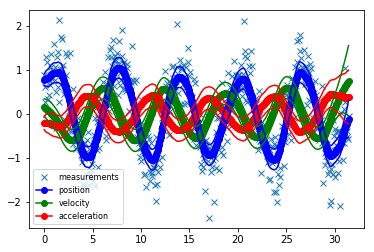

In [166]:
plotKCA(a=2)